In [413]:
import numpy as np
import snap
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

### 加载数据

In [366]:
G=snap.TUNGraph.Load(snap.TFIn('hw1-q2.graph'))
print("# of Nodes",G.GetNodes())
print("# of Edges",G.GetEdges())
def draw(G):
    HG=nx.Graph()
    for e in G.Edges():
        HG.add_edge(e.GetSrcNId(),e.GetDstNId())
    pos=nx.spring_layout(HG,seed=0)
    nx.draw(HG,pos,node_size=20)
# draw(G)

# of Nodes 1589
# of Edges 2742


In [3]:
def vec2Numpy(v):
    r=np.empty(shape=(v.Len(),))
    for i,x in enumerate(v):r[i]=x
    return r
def similar(feature,target):
    
    n1=np.linalg.norm(feature,axis=1)
    mask=np.where(n1==0)[0]
    n1[mask]=1
    
    n2=np.linalg.norm(target)
    assert n2>0
    result=feature.dot(target)/n1/n2
    #防止属性全为0的情况
    mask=np.where(n1==0)[0]
    result[mask]=0
    return result


def topKSimilar(feature,targetIndex,K):
    score=similar(feature,feature[targetIndex])
    rank=np.argsort(-score)[1:K+1]
    score=score[rank]
    return rank,score

### 特征统计
* 每个顶点的度
* 每个顶点egonet的边
* 每个顶点egonet的对外边

In [4]:
def getDegree(G):
    v=snap.TIntV()
    snap.GetDegSeqV(G,v)
    return vec2Numpy(v)[:,np.newaxis]
def getEgonetFeature(G):
    egonet_features=np.empty(shape=(G.GetNodes(),2));
    for i,node in enumerate(G.Nodes()):
        neighbours=snap.TIntV()
        degree=node.GetDeg()
        for cn in range(degree):
            nid=node.GetNbrNId(cn)
            neighbours.Add(nid)
        neighbours.Add(node.GetId())
        egonet_features[i]=snap.GetEdgesInOut(G,neighbours)
    return egonet_features
def extreactBaseFeature(G):
    f1=getDegree(G)
    f23=getEgonetFeature(G)
    feature=np.concatenate((f1,f23),axis=1)
    return feature
def get_neibour(G,t):
    '''
        打印一个节点ID=t的邻居
    '''
    n=G.GetNI(t)
    deg=n.GetDeg()
    nei=[n.GetNbrNId(i) for i in range(deg)]
    return nei

In [5]:
basefeature=extreactBaseFeature(G)
se,score=topKSimilar(basefeature,9,5)
drawSubGraph(G,9,hop=2)
for s in se:
    drawSubGraph(G,int(s),hop=2)

NameError: name 'drawSubGraph' is not defined

#### 测试代码
* 测试提取的基本特征是不是正确

In [6]:
def sanity_check_feature(feature):
    ids=np.random.choice(np.arange(len(feature)),100,False)
    ids=[1,2,3]
    for idd in ids:
        f1,f2,f3=feature[int(idd)]
        n=G.GetNI(idd)
        deg=n.GetDeg()
        
        all_node_degree=deg
        subnodes=[n.GetId()]
        for d in range(deg):
            nid=n.GetNbrNId(d)
            subnodes.append(nid)
            all_node_degree+=G.GetNI(nid).GetDeg()
        
        _f1=deg
        subgraph=snap.GetSubGraph(G,snap.TIntV.GetV(*subnodes))
        _f2=subgraph.GetEdges()
        _f3=all_node_degree-2*_f2
        
        assert _f1==f1 and _f2==f2 and _f3==f3
def print_neigh(G,t):
    '''
        打印一个节点ID=t的邻居
    '''
    nei=get_neibour(G,t)
    print("%d:"%t,nei)
sanity_check_feature(basefeature)

### 迭代特征值
$$V^{(t+1)}_v=[V_u^{(t)} \ \ \frac{1}{|N(v)|}\sum_{u \in N(v)}V_u ^{(t)}\ \ \sum_{u \in N(v)}V_u ^{(t)}]$$
* 当N(v)==0时，mean,sum项都是0

In [7]:
def recursive_feature(G,feature,K=2):
    fbase=feature.copy()
    for k in range(K):
        fmeans=np.empty_like(fbase)
        fsums=np.empty_like(fbase)
        
        for n in G.Nodes():
            neibour_feature=fbase[get_neibour(G,n.GetId())]
            if len(neibour_feature)>0:
                fmean=np.average(neibour_feature,axis=0)
                fsum=np.sum(neibour_feature,axis=0)
            else:
                fmean=np.zeros_like(fbase[0])
                fsum=np.zeros_like(fbase[0])
            fmeans[n.GetId()]=fmean
            fsums[n.GetId()]=fsum
            
        fbase=np.concatenate((fbase,fmeans,fsums),axis=1)
    return fbase

### 沙箱测试

In [8]:
def drawSubGraph(G,t,hop=2):

    NetG=nx.Graph()
    
    center=[t]
    start=0
    for _ in range(hop-1):
        _center=center[start:]
        for c in _center:
            center.extend(get_neibour(G,c))
        start+=len(_center)
    center=set(center)
    for c in center:
        adjs=get_neibour(G,c)
        for ad in adjs:
            NetG.add_edge(c,ad)
            
    pos=nx.spring_layout(NetG,seed=0)
    plt.figure(figsize=(5,5))
    nx.draw(NetG,pos,with_labels=True,label=[str(n) for n in NetG.nodes()])
    nx.draw(NetG,pos,nodelist=[t],node_color=['r'])
    plt.title('node %d and %d hop neibour'%(t,hop))

In [9]:
recur_feature=recursive_feature(G,basefeature,2)
se,score=topKSimilar(recur_feature,9,8)

0.9959848829010806
0.9946130044020561
0.9937284425239259
0.9922839741918225
0.9922413199302673
0.9922413199302673
0.9904971299996075
0.9902105236648335


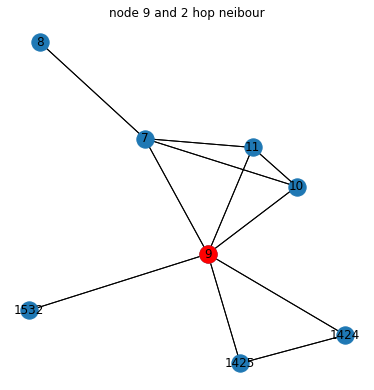

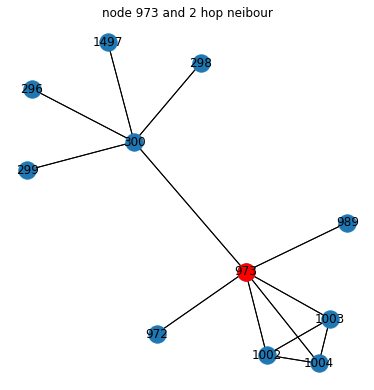

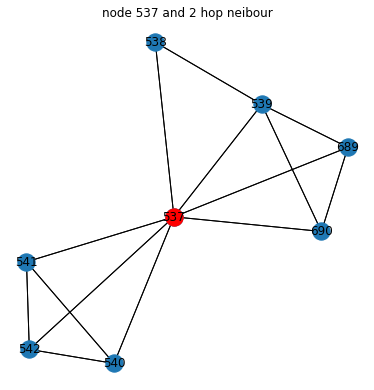

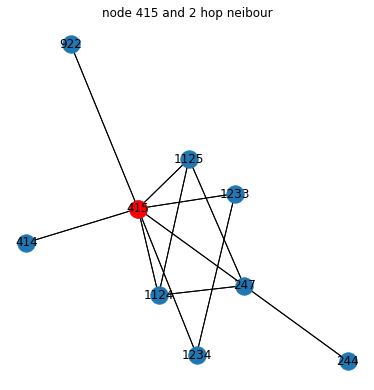

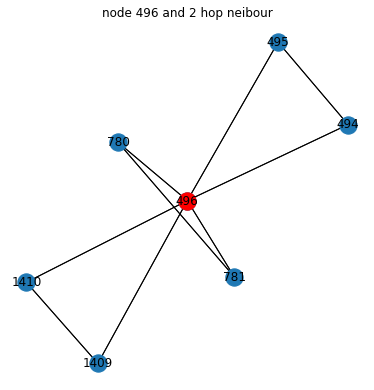

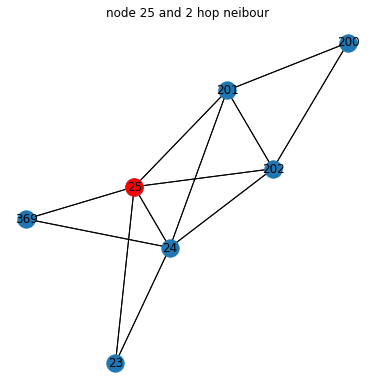

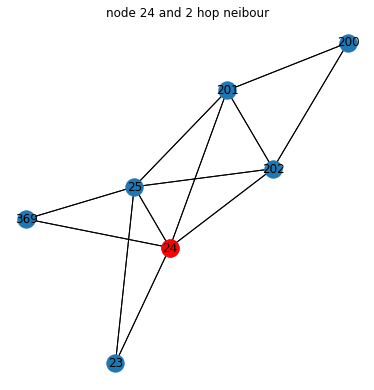

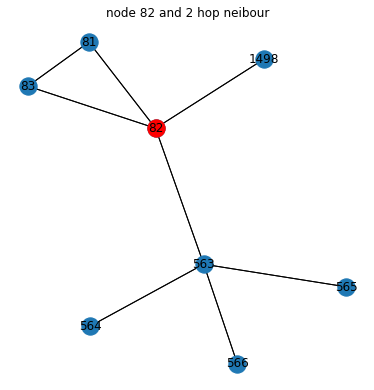

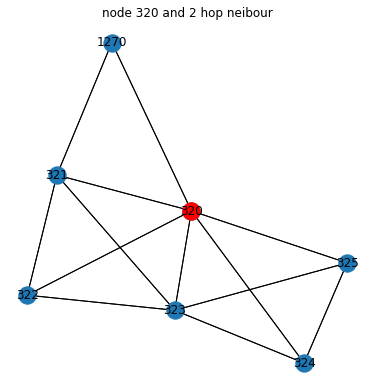

In [10]:
drawSubGraph(G,9,2)
for s,sc in zip(se,score):
    drawSubGraph(G,int(s),2)
    print(sc)

### Role Discovery

In [ ]:
score_list=similar(recur_feature,recur_feature[9])
bins_count,bins_label,_=plt.hist(score_list,bins=20)

In [ ]:
bins_count[12]

In [ ]:
# np.where(score_list>=bins_label[len(bins_count)-3] score_list<=bins_label[len(bins_count)-2])
label=12
clusters=np.logical_and(score_list>=bins_label[label],score_list<=bins_label[label+1])
idd=np.where(clusters)[0]
drawSubGraph(G,int(idd[220]))

### Lanvain聚类算法

In [414]:
def get_degree(G,nodes,weight=None):
    X=G.degree(nodes,weight=weight)
    cnt=0
    for k,v in X:
        cnt+=v
    return cnt
def get_pair_weight(G,pairs,weight=None):
    if not G.has_edge(*pairs):return 0
    w=0
    for k,v in G.get_edge_data(*pairs).items():
        if weight is None:
            w+=1
        else:w+=v[weight]
    return w

class Community():
    def __init__(self,G,nodes=None,weight='weight'):
        '''
        输入G,node表示一个节点构成一个community
        
        '''
        if nodes is not None:
            self.sigma_in=2*sum([get_pair_weight(G,(nodes[i],nodes[j]),weight) 
                               for i in range(len(nodes)) for j in range(i,len(nodes))])
            self.sigma_tot=get_degree(G,nodes,weight=weight)
            self.w=self.sigma_tot-self.sigma_in
            
            self.members=nodes[:]
            self.degrees=[G.degree(n,weight=weight) for n in nodes]
            self.weight=weight
            assert self.w>=0
        self.valid=True
    def __len__(self):
        return len(self.members)
    def get_cross_node_weight(self,G,nodei):
        k_i_in=0
        members=set(G.neighbors(nodei)).intersection(set(self.members))
        for member in members:
            k_i_in+=2*get_pair_weight(G,(member,nodei),self.weight)
        return k_i_in
    def get_cross_weight(self,G,other):
        '''
        计算nodes的每一个节点 与本Community的权值重之和
        other如果与本Community有交集，报错
        '''
        out=0
        for n in other.members:
            out+=self.get_cross_node_weight(G,n)
        return out
    def merge(self,other,nodei,K_i_in,K_i_out):
        '''
        other's community member i request to join this community
        k_i_in 是member i与community member的成对权重之和
        '''
        i=other.members.index(nodei)
        
        self.sigma_tot+=other.degrees[i]
        self.sigma_in+=K_i_in
        
        other.sigma_tot-=other.degrees[i]
        other.sigma_in-=K_i_out
        
        self.w=self.sigma_tot-self.sigma_in
        
        assert self.w>=0
        
        self.members.append(other.members[i])
        self.degrees.append(other.degrees[i])
        other.members.pop(i)
        other.degrees.pop(i)

In [427]:
def sanity_test2():
    G=nx.MultiGraph()
    G.add_edge(0,1,weight=1.2)
    G.add_edge(0,2,weight=1.3)
    c0=Community(G,[0])
    c1=Community(G,[1])
    c2=Community(G,[2])
    
    
    assert c0.sigma_tot==2.5
    assert c0.sigma_in==0
    assert c0.w==2.5
    
    c12=Community(G,[1,2])
    assert c12.sigma_tot==2.5
    assert c12.sigma_in==0
    assert c12.w==2.5
    
    
    c01=Community(G,[0,1])
    assert c01.sigma_tot==3.7
    assert c01.sigma_in==2.4
    
    c02=Community(G,[0,2])
    assert c02.sigma_tot==3.8
    assert c02.sigma_in==2.6 
    
    
    r0_1=c0.get_cross_weight(G,c1)
    assert r0_1==2.4
    
    r0_2=c0.get_cross_weight(G,c2)
    assert r0_2==2.6
    
    r1_2=c1.get_cross_weight(G,c2)
    assert r1_2==0
    
    r0_12=c0.get_cross_weight(G,c12)
    assert r0_12==2.4+2.6
    
    r1_02=c1.get_cross_weight(G,c02)
    assert r1_02==2.4
    
    r2_01=c2.get_cross_weight(G,c01)
    assert r2_01==2.6
    
    out0=c0.get_cross_node_weight(G,0)
    assert out0==0
    
    out1=c01.get_cross_node_weight(G,1)
    assert out1==2.4
    
    leave_0_01=c01.get_cross_node_weight(G,0)
    assert leave_0_01==2.4
    
    enter_0_2=c2.get_cross_node_weight(G,0)
    assert enter_0_2==2.6
    
    c2.merge(c01,0,enter_0_2,leave_0_01)
    assert c2.sigma_tot==c02.sigma_tot
    assert c2.sigma_in==c02.sigma_in

    np.testing.assert_allclose(c01.sigma_tot,c1.sigma_tot,1e-5)
    np.testing.assert_allclose(c01.sigma_in,c1.sigma_in,1e-5)
    
    assert c2.members==[2,0]
    assert c2.degrees==[1.3,2.5]
    
    
    G=nx.MultiGraph()
    G.add_edge(0,0,weight=7)
    G.add_edge(0,1,weight=4)
    G.add_edge(0,2,weight=1)
    G.add_edge(0,3,weight=1)

    G.add_edge(1,1,weight=2)
    G.add_edge(1,2,weight=1)

    G.add_edge(2,2,weight=1)
    G.add_edge(2,3,weight=3)

    G.add_edge(3,3,weight=8)
    c0_3=Community(G,[0,3],weight='weight')
    c1_2=Community(G,[1,2],weight='weight')
    a,b=modularity_add(G,1,c0_3,'weight')
    
    a,b=modularity_add(G,2,c0_3,'weight')
    assert b==10
    
    a,b=modularity_remove(G,0,c0_3,'weight')
    assert b==16
    
    a,b=modularity_remove(G,3,c0_3,'weight')
    assert b==18
    
    
    a,b=modularity_remove(G,1,c1_2,'weight')
    assert b==6
    
    a,b=modularity_remove(G,2,c1_2,'weight')
    assert b==4
    
    c0=Community(G,[0],weight='weight')
    a,b=modularity_remove(G,0,c0,'weight')
    assert b==14
    
    
    model=Louvain(G,'weight')
    G1=model.run_one_level()
    print(model.cms[0].sigma_in)
    assert model.cms[0].sigma_in==26
    assert model.cms[1].sigma_in==24
    assert model.cms[0].sigma_tot==29
    assert model.cms[1].sigma_tot==27

In [428]:
sanity_test2()

2 4
3 3
1 2
0 2
[0, 1, 2, 3] -> [1, 1, 1, 1]
1 1
0 1
3 1
2 1
[1, 1, 1, 1] -> [1, 1, 1, 1]
16


AssertionError: 

In [465]:
G=nx.MultiGraph()
G.add_edge(0,0,weight=7)
G.add_edge(0,1,weight=4)
G.add_edge(0,2,weight=1)
G.add_edge(0,3,weight=1)

G.add_edge(1,1,weight=2)
G.add_edge(1,2,weight=1)

G.add_edge(2,2,weight=1)
G.add_edge(2,3,weight=3)

G.add_edge(3,3,weight=8)
model=Louvain(G,'weight')
# G1=model.run_one_level()
c0=Community(G,[0])
c1=Community(G,[1])
c2=Community(G,[2])
c3=Community(G,[3])

ii=2
modularity_add(G,ii,c3)[0]

-0.41975308641975306

In [469]:
print(modularity_remove(G,ii,c2)[0])

-0.1111111111111111


In [468]:
(16+2+6)/18-(27/18)**2-(16/18-(20/18)**2-(7/18)**2)

-0.41975308641975295

\begin{equation}
 \sum_{\substack{s \in C}}
 \sum_{\substack{ i,j \in s}}\frac{A_{ij}}{2m}-\frac{w_iw_j}{(2m)^2}
 \end{equation}
对于一个community:
\begin{equation}
	Q=\frac{\sum_{in}}{2m}-\frac{\sum^2_{tot}}{(2m)^2}+\frac{S^2_{in}}{(2m)^2}
\end{equation}

* $\sum_{in}$表示在本community内所有节点对的权重之和.
* $\sum^2_{tot}$表示在本community内的所有节点的权重和的平方.
* $S^2_{in}$表示在本community内内的所有节点的权重平方和。
\begin{equation}
	Q(i \to C)=\frac{\sum_{in}+k_{i,in}}{2m}-\frac{(\sum_{tot}+k_i)^2}{(2m)^2}+\frac{S^2_{in}+k^2_i}{(2m)^2} \\
	\Delta Q(i \to C)=\left[\frac{\sum_{in}+k_{i,in}}{2m}-\frac{\sum_{in}}{2m}\right]-\left[\frac{(\sum_{tot}+k_i)^2}{(2m)^2}-\frac{\sum_{tot}^2}{(2m)^2}\right]+\left[\frac{S^2_{in}+k^2_i}{(2m)^2}-\frac{S^2_{in}}{(2m)^2}\right]\\
	=\left[\frac{\sum_{in}+k_{i,in}}{2m}-\frac{\sum_{in}}{2m}\right]-\left[\frac{(\sum_{tot}+k_i)^2}{(2m)^2}-\frac{\sum_{tot}^2}{(2m)^2}\right]+\left[\frac{k^2_i}{(2m)^2}\right]\\
    =\frac{k_{i,in}}{2m}-\frac{2k_i\sum_{tot}}{(2m)^2}
\end{equation}


In [476]:
def modularity_add(G,i,C,weight='weight'):
    '''
    i
    C
    '''
    m_2=2*(G.number_of_edges()-G.number_of_selfloops())
    
    ki=G.degree(i,weight=weight)
    k_i_in=C.get_cross_node_weight(G,i)+2*get_pair_weight(G,(i,i),weight)
    sigma_tot=C.sigma_tot
    
    r=k_i_in/m_2-(2*ki*sigma_tot)/(m_2**2)
    return r,k_i_in
def modularity_remove(G,i,C,weight='weight'):
    m_2=2*(G.number_of_edges()-G.number_of_selfloops())
    ki=G.degree(i,weight=weight)
    k_i_out=C.get_cross_node_weight(G,i)
    sigma_tot=C.sigma_tot
    r=-k_i_out/m_2+(2*ki*sigma_tot-2*ki**2)/(m_2**2)
    return r,k_i_out
class Louvain():
    def __init__(self,G,weight='weight'):
        self.G=G
        self.nodes=[]
        self.cms=[]
        self.node_community=[]
        self.weight=weight
        for i,node in enumerate(G.nodes()):
            self.cms.append(Community(G,[node],weight))
            self.nodes.append(node)
            self.node_community.append(i)
            
    def run_one_level(self):
        
        while True:
            rnd=np.random.permutation(self.nodes)
            old_community=self.node_community[:]

            for node in rnd:
                community_index=self.node_community[node]
                current_C=self.cms[community_index]

                dQmax=0
                chioce=-1
                k_in=-1
                leave_Q,k_out=modularity_remove(G,node,current_C,self.weight)
                if len(current_C.members)==0:leave_Q=0
                ss=0
                for i,cm in enumerate(self.cms):
                    if i==current_C:continue
                    if len(cm.members)==0:continue
                    ss+=1
                    enter_Q,_kin=modularity_add(G,node,cm,self.weight)
                    dQ=enter_Q+leave_Q
                    if dQ>dQmax:
                        dQmax=dQ
                        chioce=i
                        k_in=_kin
                if chioce!=-1 and chioce!=community_index:
                    self.cms[chioce].merge(current_C,node,k_in,k_out)
                    self.node_community[node]=chioce
                print(node,ss)
            print(old_community,'->',self.node_community)
            if old_community==self.node_community:
                break
            else:
                old_community=self.node_community
        mask=[]
        mask_dict={}
        for i in range(len(self.cms)):
            if len(self.cms[i].members)>0:
                mask_dict[i]=len(mask)
                mask.append(i)
                
        self.cms=[self.cms[i] for i in mask]
        self.node_community=[mask_dict[k] for k in self.node_community]
        return self.createNewGraph()
    def createNewGraph(self):
        G=nx.MultiGraph()
        for i,cm in enumerate(self.cms):
            if cm.sigma_in >0:
                G.add_edge(i,i,weight=cm.sigma_in/2)
        for i in range(len(self.cms)-1):
            for j in range(i+1,len(self.cms)):
                w=self.cms[i].get_cross_weight(self.G,self.cms[j])/2
                if w>0:
                    G.add_edge(i,j,weight=w)
        return G

In [477]:
from utils import makeChengfGraph

In [478]:
G,Id2Index,Index2Id,_=makeChengfGraph('data/demo.json')
# G=nx.MultiGraph()
# G.add_edge(0,1,weight=1.2)
# G.add_edge(0,2,weight=1.3)

#全部节点数量,有临边节点数量,#边数量(双向): 364 363 540


In [479]:
model=Louvain(G,'weight')
G1=model.run_one_level()

311 363
64 362
260 361
216 360
178 359
308 358
252 357
301 356
144 355
141 354
206 353
146 352
77 351
131 350
198 349
317 348
254 347
74 347
251 346
29 345
158 344
79 343
352 342
231 341
259 340
112 339
30 338
164 337
42 336
298 335
286 334
289 333
154 332
143 331
181 330
234 329
347 328
204 327
5 326
239 325
223 324
332 323
265 322
82 321
242 320
118 319
255 318
136 317
40 316
72 315
24 314
33 313
349 312
84 311
323 310
103 309
62 308
81 307
297 306
218 305
99 304
153 303
167 302
106 301
172 300
353 299
269 298
67 297
258 297
290 296
10 295
184 294
338 293
156 292
107 291
120 290
142 289
217 289
85 288
56 287
36 286
227 285
325 284
295 283
277 282
78 281
80 280
55 279
27 278
348 277
110 276
95 275
263 274
69 273
117 272
35 271
346 270
151 269
169 268
299 267
163 266
31 265
249 264
88 263
37 262
247 261
46 260
28 259
3 258
202 257
175 256
65 255
155 254
294 253
303 252
90 251
34 250
12 249
315 248
355 247
195 246
145 245
135 244
275 243
326 242
343 241
75 240
66 239
212 238
133 237
226

In [480]:
G1.nodes()

NodeView((0, 1, 2, 3, 4))

In [481]:
G1.edges()

MultiEdgeDataView([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 3), (3, 4), (4, 4)])

In [482]:
get_degree(G1,[2],weight='weight')

214.0

In [483]:
model1=Louvain(G1,'weight')
G2=model1.run_one_level()

0 5
4 4
1 4
3 3
2 3
[0, 1, 2, 3, 4] -> [4, 3, 4, 2, 3]
3 3
4 3
2 3
0 3
1 3
[4, 3, 4, 2, 3] -> [4, 4, 2, 2, 2]
0 2
3 2
1 2
2 2
4 2
[4, 4, 2, 2, 2] -> [2, 4, 4, 4, 2]
1 2
4 2
3 2
2 2
0 2
[2, 4, 4, 4, 2] -> [4, 2, 4, 4, 4]
3 2
4 2
2 2
1 2
0 2
[4, 2, 4, 4, 4] -> [2, 4, 4, 2, 2]
0 2
3 2
2 2
4 2
1 2
[2, 4, 4, 2, 2] -> [2, 4, 2, 2, 4]
2 2
0 2
4 2
3 2
1 2
[2, 4, 2, 2, 4] -> [2, 2, 4, 2, 2]
2 2
3 2
4 2
0 2
1 2
[2, 2, 4, 2, 2] -> [4, 2, 4, 4, 4]
4 2
1 2
2 2
3 2
0 2
[4, 2, 4, 4, 4] -> [4, 2, 2, 4, 2]
0 2
1 2
4 2
2 2
3 2
[4, 2, 2, 4, 2] -> [4, 4, 2, 2, 2]
0 2
2 2
4 2
1 2
3 2
[4, 4, 2, 2, 2] -> [2, 2, 4, 4, 2]
0 2
1 2
4 2
2 2
3 2
[2, 2, 4, 4, 2] -> [4, 2, 2, 4, 2]
2 2
3 2
4 2
1 2
0 2
[4, 2, 2, 4, 2] -> [2, 2, 4, 2, 4]
2 2
4 2
1 2
0 2
3 2
[2, 2, 4, 2, 4] -> [2, 4, 4, 2, 4]
0 2
3 2
1 2
2 2
4 2
[2, 4, 4, 2, 4] -> [2, 2, 4, 2, 4]
2 2
4 2
0 2
3 2
1 2
[2, 2, 4, 2, 4] -> [4, 2, 4, 2, 4]
4 2
0 2
3 2
1 2
2 2
[4, 2, 4, 2, 4] -> [4, 2, 2, 4, 2]
1 2
3 2
0 2
2 2
4 2
[4, 2, 2, 4, 2] -> [2, 4, 4, 2, 2]
2 2
4 2
3 

KeyboardInterrupt: 

In [ ]:
for x in G1.nodes():
    print(get_degree(G1,[x],'weight'))

In [205]:
for x in G1.edges():
    print(x[0],x[1],get_pair_weight(G1,(x[0],x[1]),'weight'))

0 0 47.0
0 1 8.0
0 2 12.0
0 3 14.0
0 4 4.0
1 1 119.0
1 2 46.0
1 3 18.0
1 4 2.0
2 2 151.0
2 3 20.0
2 4 4.0
3 3 78.0
3 4 6.0
4 4 11.0


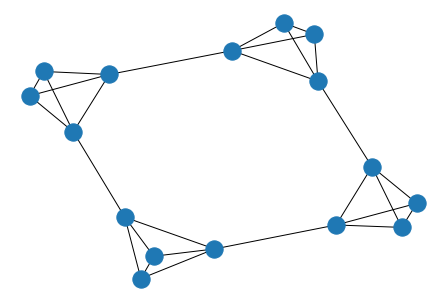

In [418]:
G=nx.MultiGraph()
G.add_edge(0,0,weight=7)
G.add_edge(0,1,weight=4)
G.add_edge(0,2,weight=1)
G.add_edge(0,3,weight=1)

G.add_edge(1,1,weight=2)
G.add_edge(1,2,weight=1)

G.add_edge(2,2,weight=1)
G.add_edge(2,3,weight=3)

G.add_edge(3,3,weight=8)
def createGraph():
    G=nx.MultiGraph()
    
    for i in range(4):
        s=4*i
        G.add_edge(s,s+1,weight=1)
        G.add_edge(s,s+2,weight=1)
        G.add_edge(s,s+3,weight=1)
        G.add_edge(s+1,s+2,weight=1)
        G.add_edge(s+1,s+3,weight=1)
        G.add_edge(s+2,s+3,weight=1)
    
    G.add_edge(1,4,weight=1)
    G.add_edge(6,9,weight=1)
    G.add_edge(11,14,weight=1)
    G.add_edge(12,3,weight=1)
    return G
G=createGraph()
pos=nx.spring_layout(G,seed=0)
nx.draw(G,pos)

In [419]:
model=Louvain(G,'weight')
G1=model.run_one_level()
# for xx in model.cms:
#     print(xx.sigma_in)
# for x,y in G.edges():
#     print(x,'->',y,get_pair_weight(G,(x,y),'weight'))

3 16
11 15
4 14
2 13
7 12
1 11
12 10
10 9
15 8
9 7
13 6
0 6
8 6
14 6
5 5
6 5
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] -> [0, 0, 0, 0, 5, 5, 5, 5, 8, 8, 8, 8, 13, 13, 13, 13]
0 4
9 4
13 4
4 4
15 4
10 4
11 4
3 4
2 4
7 4
1 4
14 4
12 4
5 4
8 4
6 4
[0, 0, 0, 0, 5, 5, 5, 5, 8, 8, 8, 8, 13, 13, 13, 13] -> [0, 0, 0, 0, 5, 5, 5, 5, 8, 8, 8, 8, 13, 13, 13, 13]


In [420]:
model1=Louvain(G1,'weight')
G2=model1.run_one_level()

0 4
1 3
3 3
2 2
[0, 1, 2, 3] -> [1, 2, 1, 1]
2 2
3 2
1 2
0 2
[1, 2, 1, 1] -> [2, 1, 2, 2]
0 2
2 2
3 2
1 1
[2, 1, 2, 2] -> [1, 1, 1, 1]
2 1
3 1
1 1
0 1
[1, 1, 1, 1] -> [1, 1, 1, 1]


In [421]:
model.node_community

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]

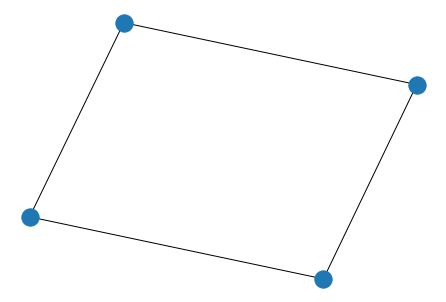

In [422]:
pos=nx.spring_layout(G1,seed=0)
nx.draw(G1,pos)

In [408]:
c0=Community(G1,[0])
c1=Community(G1,[1])

In [411]:
modularity_add(G1,0,c1)

(-0.65625, 14.0)

In [412]:
modularity_remove(G1,0,c0)

(-0.75, 12.0)

In [475]:
# for x in xx
G.number_of_selfloops()

4